In [69]:
import json
import os
from pathlib import Path
from itertools import permutations

import joblib
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, welch
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import medfilt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import (
    GroupShuffleSplit,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report


from xgboost import XGBClassifier


In [70]:
# Set up global variables

# Base directory containing the Kaggle bundle and model outputs.
BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025") 
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_OUT = MODEL_DIR / 'rf_amplitude.joblib'
SUMMARY_OUT = MODEL_OUT.with_suffix('.json')
SUBMISSION_OUT = MODEL_DIR / 'rf_amplitude_submission.csv'

# Random Forest hyperparameters and shared constants.
TEST_SIZE = 0.25
N_ESTIMATORS = 400
MAX_DEPTH = None
RANDOM_STATE = 1234

VALID_LABELS = [0, 1, 2, 3, 4]
SAMPLING_RATE = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = SAMPLING_RATE * EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025


## Load Data and Create Features

In [71]:
# Load data and store it in simple dataframe

def load_data(path):
    signals = {}
    for root, _, files in os.walk(path):
        for file in sorted(files):  # Sort for consistency
            file_path = os.path.join(root, file)
            # Extract the actual signal number from filename (e.g., "signal_8.npy" -> 8)
            signal_num = int(file.split('_')[-1].split('.')[0])
            signals[signal_num] = np.load(file_path)
    return signals

def format_data(train):
    # Define base columns
    base_columns = ['captor_0', 'captor_1', 'captor_2', 'captor_3', 'captor_4', 'num_epoch', 'num_signal']
    
    # Add target column only for training data
    if train:
        columns = base_columns.copy()
        columns.insert(5, 'target')  # Insert target at position 5 (after captors, before num_epoch)
        signals = load_data('signals_train')
        targets = load_data('targets_train')
    else:
        columns = base_columns
        signals = load_data('signals_test')
    
    main_df = pd.DataFrame(columns=columns)

    for signal_idx in signals.keys():
        signal = signals[signal_idx]

        ########### Scale the signal
        signal = (signal - signal.mean(axis=1, keepdims=True)) / (signal.std(axis=1, keepdims=True) + 1e-8)
        
        ###########
        if train:
            target = targets[signal_idx]
        
        # Split signal into chunks of 3000
        splited_signal = np.array_split(signal, np.arange(3000, signal.shape[1], 3000), axis=1)
        
        # Create DataFrame for this signal
        df = pd.DataFrame(
            index=range(len(splited_signal)),
            columns=[f"captor_{i}" for i in range(5)]
        )
        
        # Fill captor data
        for idx, signal_matrix in enumerate(splited_signal):
            for captor in range(signal_matrix.shape[0]):
                df.loc[idx, f"captor_{captor}"] = signal_matrix[captor, :].squeeze()
        
        # Add metadata columns
        df['num_epoch'] = df.index
        df['num_signal'] = signal_idx
        
        # Add target only for training data
        if train:
            df['target'] = target
        
        # Reorder columns to match main_df structure
        df = df[columns]
        
        # Concatenate with main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)
        main_df = main_df.sort_values(['num_signal', 'num_epoch'])

    return main_df


In [72]:
# Feature extraction of previous dataframe          

def extract_time_features(signal):
    """Extract time domain features from a signal."""
    features = {
        'std': float(np.std(signal)),
        'mean': float(np.mean(signal)),
        'min': float(np.min(signal)),
        'max': float(np.max(signal)),
        'ptp': float(np.ptp(signal)),
        'skew': float(skew(signal)),
        'kurtosis': float(kurtosis(signal)),
        'rms': float(np.sqrt(np.mean(signal**2))),
        'median': float(np.median(signal))
    }
    return features


def spectral_entropy(psd):
    """Spectral entropy from a PSD array."""
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    return -np.sum(psd_norm * np.log(psd_norm + 1e-12))


def permutation_entropy(signal, order=3, delay=1):
    """Permutation entropy of a 1D signal."""
    n = len(signal)
    perms = list(permutations(range(order)))
    c = np.zeros(len(perms))

    for i in range(n - delay * (order - 1)):
        pattern = signal[i:i + delay * order:delay]
        rank = tuple(np.argsort(pattern))
        c[perms.index(rank)] += 1

    p = c / np.sum(c) if np.sum(c) > 0 else c
    p = p[p > 0]

    return -np.sum(p * np.log(p))



def extract_frequency_features(signal):
    """Extract frequency domain + entropy features from a signal."""
    features = {}
    
    # PSD using Welch (already correct)
    freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=min(256, len(signal)))
    total_power = np.sum(psd)

    # ---------- GLOBAL SPECTRAL ENTROPY ----------
    features['spectral_entropy'] = float(spectral_entropy(psd))

    # Define sleep frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'sigma': (12, 15),
        'beta': (13, 30)
    }

    # ---------- BAND FEATURES + BAND ENTROPY ----------
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)

        if np.any(band_mask):
            band_psd = psd[band_mask]
            band_power = np.sum(band_psd)

            features[f'{band_name}_power'] = float(band_power)
            features[f'{band_name}_rel_power'] = float(
                band_power / total_power if total_power > 0 else 0
            )

            # Band spectral entropy
            features[f'{band_name}_entropy'] = float(
                spectral_entropy(band_psd)
            )
        else:
            features[f'{band_name}_power'] = 0.0
            features[f'{band_name}_rel_power'] = 0.0
            features[f'{band_name}_entropy'] = 0.0

    # Spectral edge frequency (95%)
    cumsum_psd = np.cumsum(psd)
    if len(cumsum_psd) > 0 and cumsum_psd[-1] > 0:
        sef_idx = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
        features['sef95'] = float(freqs[sef_idx[0]] if len(sef_idx) > 0 else 0)

    features['total_power'] = float(total_power)

    return features


def extract_channel_features(channel_signal):
    """Extract all features for a single channel."""
    time_features = extract_time_features(channel_signal)
    freq_features = extract_frequency_features(channel_signal)

    # ---------- PERMUTATION ENTROPY ----------
    time_features['permutation_entropy'] = float(
        permutation_entropy(channel_signal, order=3, delay=1)
    )

    return {**time_features, **freq_features}


def extract_cross_channel_features(channel_signals):
    """Extract features that involve multiple channels."""
    features = {}
    
    # Correlations between channel pairs
    for i in range(NUM_CHANNELS):
        for j in range(i+1, NUM_CHANNELS):
            corr, _ = pearsonr(channel_signals[i], channel_signals[j])
            features[f'corr_ch{i}_ch{j}'] = float(corr)
    
    # Spatial variability
    channel_stds = [np.std(signal) for signal in channel_signals]
    features['spatial_std'] = float(np.std(channel_stds))
    features['spatial_mean_std'] = float(np.mean(channel_stds))
    
    return features

def add_temporal_context(features_df, window=3):
    """Add rolling statistics to capture temporal patterns."""
    # Add rolling statistics for key features
    key_features = ['ch0_delta_power', 'ch0_alpha_power', 'ch0_sigma_power']
    
    for col in key_features:
        if col in features_df.columns:
            # Rolling statistics within each signal
            for signal_id in features_df['num_signal'].unique():
                mask = features_df['num_signal'] == signal_id
                
                # Rolling mean
                rolling_mean = features_df.loc[mask, col].rolling(window, center=True).mean()
                features_df.loc[mask, f'{col}_roll_mean_{window}'] = rolling_mean
                
                # Rolling std
                rolling_std = features_df.loc[mask, col].rolling(window, center=True).std()
                features_df.loc[mask, f'{col}_roll_std_{window}'] = rolling_std
                
                # Difference from previous epoch
                features_df.loc[mask, f'{col}_diff_{window}'] = features_df.loc[mask, col].diff()
    
    # Fill NaN values
    features_df = features_df.bfill().ffill().fillna(0)
    
    return features_df

def process_single_epoch(row):
    """Process a single epoch (row) to extract all features."""
    features = {}
    
    # Process each channel
    channel_signals = []
    for ch in range(NUM_CHANNELS):
        # Get signal for this channel
        signal = np.array(row[f'captor_{ch}'])
        
        # Ensure correct length
        if len(signal) != SAMPLES_PER_EPOCH:
            if len(signal) < SAMPLES_PER_EPOCH:
                signal = np.pad(signal, (0, SAMPLES_PER_EPOCH - len(signal)), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_EPOCH]
        
        # Extract channel features
        ch_features = extract_channel_features(signal)
        
        # Add channel prefix to feature names
        for key, value in ch_features.items():
            features[f'ch{ch}_{key}'] = value
        
        channel_signals.append(signal)
    
    # Extract cross-channel features
    cross_features = extract_cross_channel_features(channel_signals)
    features.update(cross_features)
    
    # Add metadata
    features['num_epoch'] = int(row['num_epoch'])
    features['num_signal'] = int(row['num_signal'])
    
    return features


def add_lagged_features(df_features):
    # top 20 features from previously trained XGboost, used to create lagged features
    top_20_features = ['ch2_permutation_entropy',
    'ch1_beta_entropy',
    'ch3_alpha_rel_power',
    'ch4_sef95',
    'ch3_beta_entropy',
    'ch3_permutation_entropy',
    'ch2_sigma_power',
    'ch3_delta_power',
    'ch0_delta_rel_power',
    'ch0_sigma_power_roll_mean_3',
    'ch4_alpha_power',
    'ch0_delta_power_roll_mean_3',
    'ch2_sef95',
    'ch3_beta_rel_power',
    'ch2_delta_rel_power',
    'ch1_permutation_entropy',
    'ch4_spectral_entropy',
    'ch2_delta_power',
    'ch0_delta_power_roll_mean_50',
    'ch0_beta_entropy']    
    

    lags = [-5, -4, -3, -2, -1, 1] 

    # 4. Vectorized implementation (No loops over rows!)
    for lag in lags:
        shifted_data = df_features.groupby('num_signal')[top_20_features].shift(lag)
        shifted_data.columns = [f"lagged_feature_{col}_{lag}" for col in top_20_features]
        df_features = pd.concat([df_features, shifted_data], axis=1)

    df_features = df_features.bfill().ffill().fillna(0)
    return df_features


def create_features_parallel(df):
    print(f"Processing {len(df)} epochs in parallel...")
    
    # Run process_single_epoch across all available CPU cores
    results = Parallel(n_jobs=-1)(
        delayed(process_single_epoch)(row) for _, row in df.iterrows()
    )
    
    features_df = pd.DataFrame(results)
    
    # Temporal context remains sequential as it depends on ordering
    print("Adding temporal context...")
    features_df = add_temporal_context(features_df, 3)
    features_df = add_temporal_context(features_df, 50)
    features_df = add_temporal_context(features_df, 500)

    features_df = add_lagged_features(features_df)
    return features_df


In [73]:
# Create the submission file

def create_submission(df_test, predictions, file_name = ''):
    # num_signal already contains the correct signal numbers
    identifiers = df_test['num_signal'] * 10000 + df_test['num_epoch']
    
    submission = pd.DataFrame({
        'identifier': identifiers.astype(int),
        'target': predictions.astype(int)
    })
    
    submission = submission.sort_values('identifier').reset_index(drop=True)
    submission.to_csv(file_name + 'submission.csv', index=False)

    # Check wether everything wnt well while creating the submission file
    df_ok = pd.read_csv('sample.csv')
    set1 = set(submission.identifier)
    set2 = set(df_ok.identifier)
    difference = set1.symmetric_difference(set2)
    print('labels that are not in boths sets : ', difference)
    
    return submission

## Data exploration

In [74]:
df = format_data(True)
df_features = create_features_parallel(df)

Processing 7433 epochs in parallel...
Adding temporal context...


In [75]:
# Merge target variable into df_features for analysis
# We merge on num_signal and num_epoch to ensure alignment
if 'target' not in df_features.columns:
    df_features_exp = df_features.merge(
        df[['num_signal', 'num_epoch', 'target']], 
        on=['num_signal', 'num_epoch'], 
        how='left'
    )
else:
    df_features_exp = df_features.copy()

print(f"Exploration DataFrame Shape: {df_features_exp.shape}")
print(f"Missing Values:\n{df_features_exp.isnull().sum().sum()}")
display(df_features_exp.head())

Exploration DataFrame Shape: (7433, 302)
Missing Values:
0


,ch0_std,ch0_mean,ch0_min,ch0_max,ch0_ptp,ch0_skew,ch0_kurtosis,ch0_rms,ch0_median,ch0_permutation_entropy,...,lagged_feature_ch0_delta_power_roll_mean_3_1,lagged_feature_ch2_sef95_1,lagged_feature_ch3_beta_rel_power_1,lagged_feature_ch2_delta_rel_power_1,lagged_feature_ch1_permutation_entropy_1,lagged_feature_ch4_spectral_entropy_1,lagged_feature_ch2_delta_power_1,lagged_feature_ch0_delta_power_roll_mean_50_1,lagged_feature_ch0_beta_entropy_1,target
0,0.407679,-0.001382,-1.328406,1.402134,2.730540,0.013364,-0.019679,0.407682,-0.006623,1.423584,...,0.044670,12.500000,0.038981,0.195043,1.474482,3.305107,0.034539,0.270098,3.436783,0
1,0.372597,0.000835,-1.317558,1.242183,2.559741,0.052709,0.042525,0.372598,-0.009559,1.417221,...,0.044670,12.500000,0.038981,0.195043,1.474482,3.305107,0.034539,0.270098,3.436783,0
2,0.352560,0.000193,-1.133212,1.059292,2.192503,-0.029183,-0.143240,0.352560,0.001246,1.410325,...,0.044670,12.109375,0.038978,0.214768,1.484600,3.204162,0.031435,0.270098,3.457426,0
3,0.341169,-0.001315,-1.022033,1.353148,2.375182,0.049045,-0.003227,0.341172,-0.001962,1.413915,...,0.041504,11.718750,0.034164,0.204683,1.477498,3.149180,0.025380,0.270098,3.450589,0
4,0.340090,0.002265,-1.052574,1.544688,2.597262,0.052002,0.115995,0.340097,0.001264,1.423665,...,0.047259,12.890625,0.041828,0.176872,1.486691,3.277381,0.018046,0.270098,3.419298,0


C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\3826747065.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df_features_exp, palette='viridis')


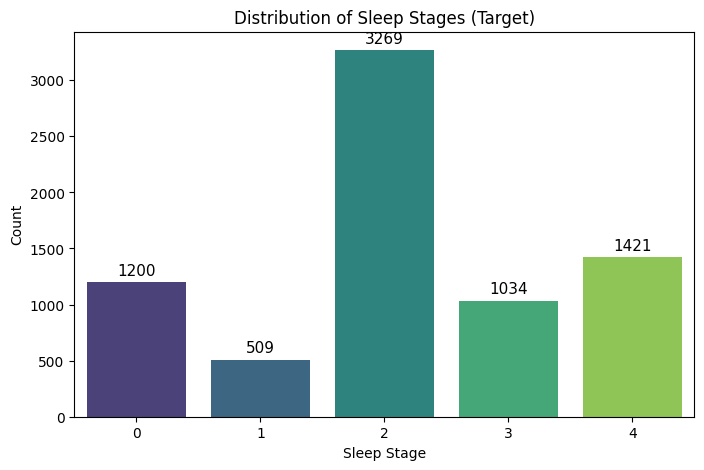

In [76]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df_features_exp, palette='viridis')
plt.title('Distribution of Sleep Stages (Target)')
plt.xlabel('Sleep Stage')
plt.ylabel('Count')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

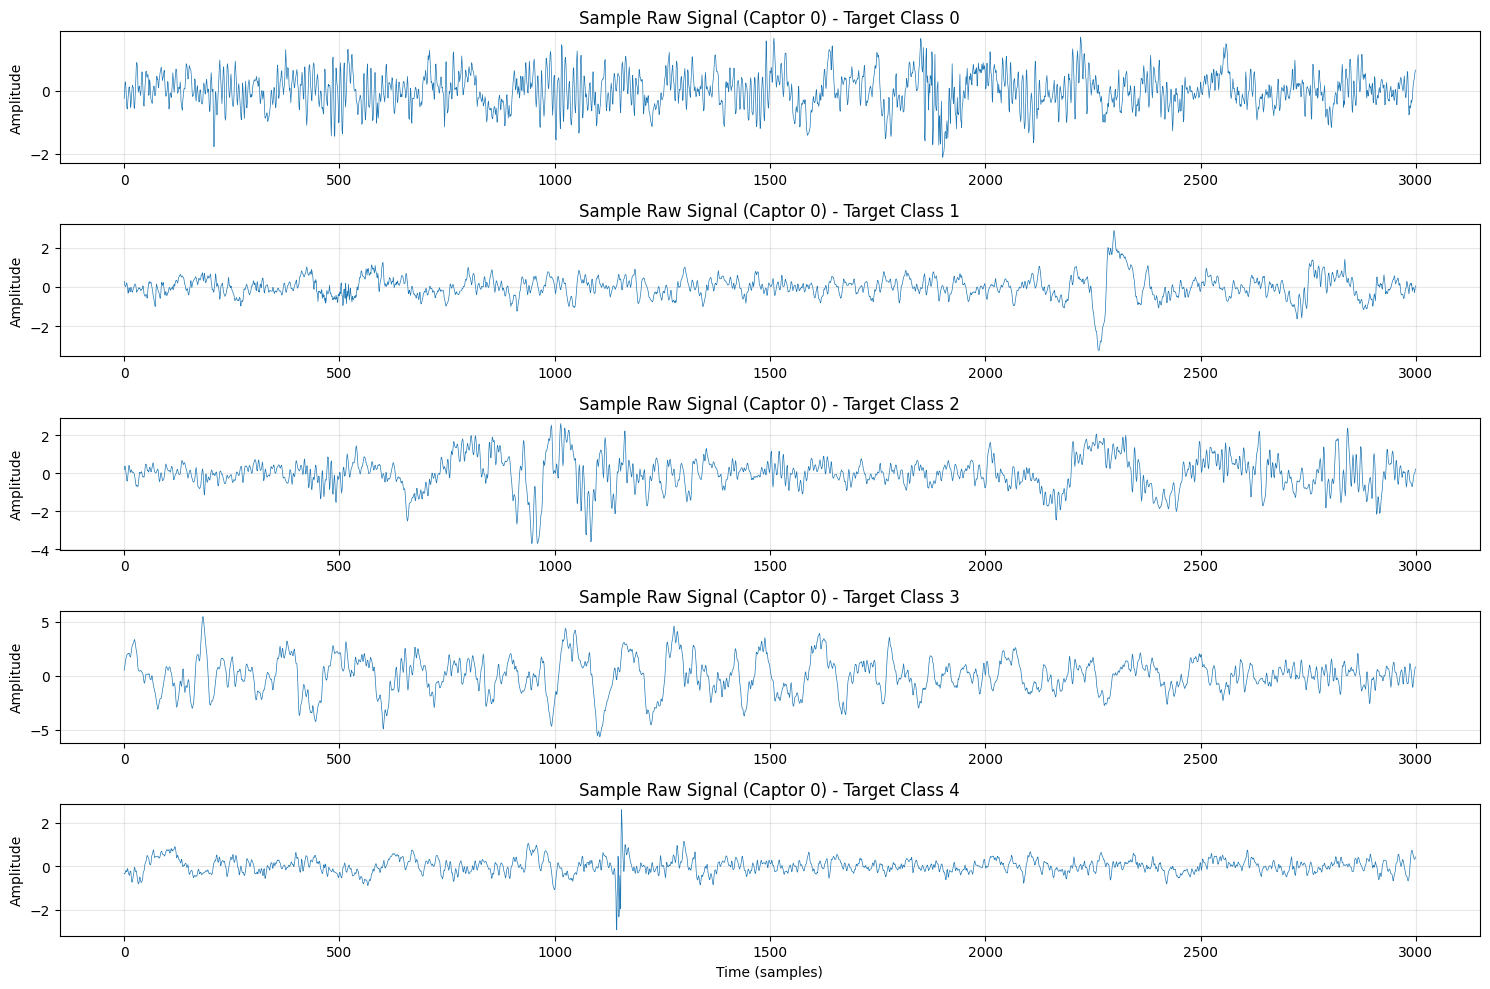

In [77]:
# Plot one example signal for each class from 'captor_0'
unique_classes = sorted(df_features_exp['target'].unique())

plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_classes):
    # Get a random row with this label
    sample_row = df[df['target'] == label].sample(1).iloc[0]
    signal_data = sample_row['captor_0'] # Assuming captor_0 contains the numpy array
    
    plt.subplot(len(unique_classes), 1, i + 1)
    plt.plot(signal_data, linewidth=0.5)
    plt.title(f'Sample Raw Signal (Captor 0) - Target Class {label}')
    plt.ylabel('Amplitude')
    if i == len(unique_classes) - 1:
        plt.xlabel('Time (samples)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

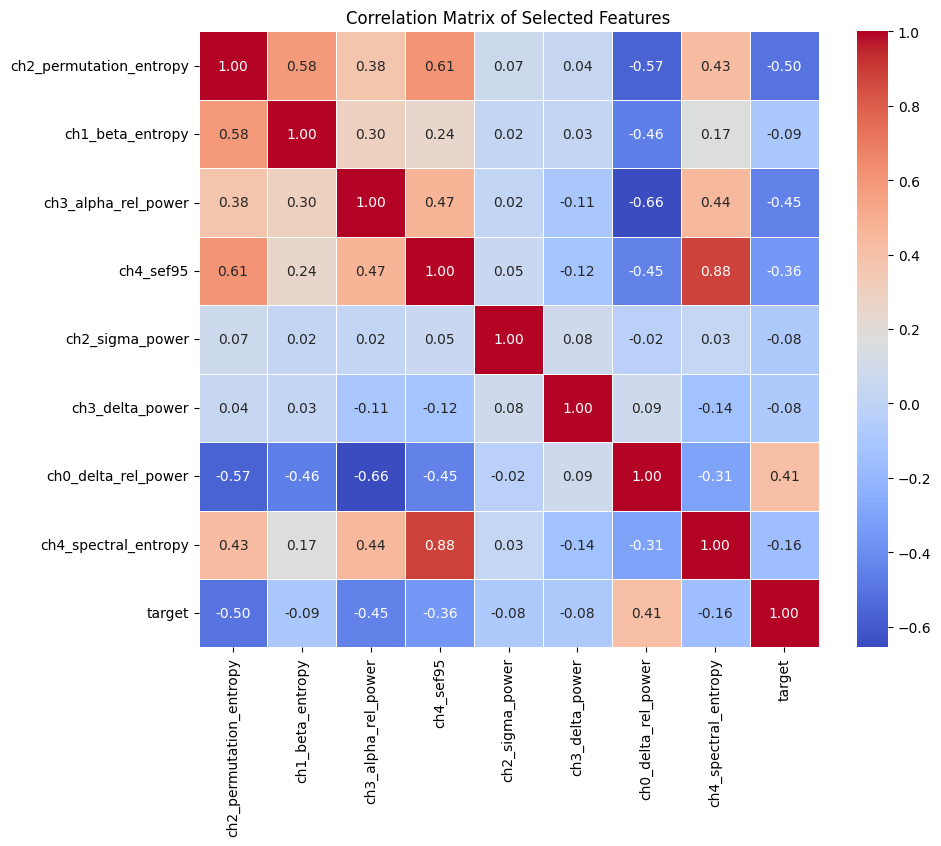

In [78]:
# List of interesting features
selected_feats = [
    'ch2_permutation_entropy', 'ch1_beta_entropy', 'ch3_alpha_rel_power', 
    'ch4_sef95', 'ch2_sigma_power', 'ch3_delta_power', 
    'ch0_delta_rel_power', 'ch4_spectral_entropy', 'target'
]

# Filter for columns that actually exist in the dataframe
cols_to_plot = [c for c in selected_feats if c in df_features_exp.columns]

plt.figure(figsize=(10, 8))
correlation_matrix = df_features_exp[cols_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

## Build Model

In [79]:
# Prepare the data

X_df, y = df_features.drop(['num_signal'], axis=1), df['target'].astype(int)

# 1. Split 
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=12)


# 2. Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### XGBoost and Random Forest simple model

In [80]:
# XGboost model 
model_xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)


# Random Forest model
model_rf = RandomForestClassifier(
    max_depth=15, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=2, 
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)


model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)


model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)



# Evaluate the model
print('Results for XGB')
f1_macro = f1_score(y_test, predictions_xgb, average='macro')
f1_micro = f1_score(y_test, predictions_xgb, average='micro')
f1_per_class = f1_score(y_test, predictions_xgb, average=None)

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
for i, score in enumerate(f1_per_class):
    print(f"Class {i} F1 Score: {score:.4f}")


print('-------\n         \n-------')
print('Results for Random Forest')
f1_macro = f1_score(y_test, predictions_rf, average='macro')
f1_micro = f1_score(y_test, predictions_rf, average='micro')
f1_per_class = f1_score(y_test, predictions_rf, average=None)

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
for i, score in enumerate(f1_per_class):
    print(f"Class {i} F1 Score: {score:.4f}")

Results for XGB
F1 Score (macro): 0.8862
F1 Score (micro): 0.9240
Class 0 F1 Score: 0.9261
Class 1 F1 Score: 0.6596
Class 2 F1 Score: 0.9395
Class 3 F1 Score: 0.9587
Class 4 F1 Score: 0.9470
-------
         
-------
Results for Random Forest
F1 Score (macro): 0.8335
F1 Score (micro): 0.8917
Class 0 F1 Score: 0.9064
Class 1 F1 Score: 0.5157
Class 2 F1 Score: 0.9157
Class 3 F1 Score: 0.9299
Class 4 F1 Score: 0.9000


In [81]:
## Create submission, so we use whole dataset for training

X_df, y = df_features.drop(['num_signal'], axis=1), df['target']
df_test = format_data(False)
X_test = create_features_parallel(df_test).drop(['num_signal'], axis=1)


# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test = scaler.transform(X_test)


## We use the XGB model that performed better
model_xgb.fit(X_train, y.astype(int))
predictions = model_xgb.predict(X_test)


r = create_submission(df_test, predictions, "simple_XGBoost")
r.head(5)

Processing 4077 epochs in parallel...
Adding temporal context...
labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2


### Train model, and use priors and transitions

In [82]:
## Fonctions for smoothening

def calculate_priors_and_transitions(y_train):
    classes = np.unique(y_train)
    n_classes = len(classes)
    
    # 1. Transition Matrix
    trans_mat = np.zeros((n_classes, n_classes))
    y = np.array(y_train).astype(int)
    
    # Count transitions (i -> j)
    for i in range(len(y) - 1):
        trans_mat[y[i], y[i+1]] += 1
        
    # Normalize rows (probabilities must sum to 1)
    trans_mat = trans_mat / (trans_mat.sum(axis=1, keepdims=True) + 1e-12)
    
    # 2. Priors (Initial state probabilities)
    priors = np.bincount(y, minlength=n_classes) / len(y)
    
    return np.log(priors + 1e-12), np.log(trans_mat + 1e-12)


def viterbi_decoding(probs, log_priors, log_trans_mat):
    n_obs, n_classes = probs.shape
    
    # Log probabilities to prevent underflow
    log_probs = np.log(probs + 1e-12)
    
    # Initialize DP tables
    # path_score[t, s]: max probability of a path ending at time t in state s
    path_score = np.zeros((n_obs, n_classes))
    # backpointer[t, s]: the state at t-1 that led to best path at t, s
    backpointer = np.zeros((n_obs, n_classes), dtype=int)
    
    # Base case: first epoch
    path_score[0, :] = log_priors + log_probs[0, :]
    
    # Forward Pass
    for t in range(1, n_obs):
        for s in range(n_classes):
            # Calculate transition from all previous states to current state s
            # Score = Score(t-1) + Transition(prev->s) + Emission(s)
            scores = path_score[t-1, :] + log_trans_mat[:, s] + log_probs[t, s]
            
            # Store best score and best previous state
            path_score[t, s] = np.max(scores)
            backpointer[t, s] = np.argmax(scores)
            
    # Backward Pass (Backtracking)
    best_path = np.zeros(n_obs, dtype=int)
    
    # Start from the state with best final score
    best_path[-1] = np.argmax(path_score[-1, :])
    
    # Trace back
    for t in range(n_obs - 2, -1, -1):
        best_path[t] = backpointer[t+1, best_path[t+1]]
        
    return best_path

In [83]:

# ---------------------------------------------------------
# 1. PREPARE DATA & SPLIT BY SIGNAL (CRITICAL for Viterbi)
# ---------------------------------------------------------

# We need 'num_signal' to keep sequences intact, so we extract it before dropping
groups = df_features['num_signal']
X = df_features.drop(['num_signal'], axis=1)
y = df['target'].astype(int)

# GroupShuffleSplit ensures that if Signal_1 is in Test, ALL epochs of Signal_1 are in Test.
# This preserves the time sequence needed for HMM/Viterbi.
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=12)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# We need the signal IDs for the test set to run Viterbi loop later
test_groups = groups.iloc[test_idx] 

# ---------------------------------------------------------
# 2. SCALE
# ---------------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------------------------------------------
# 3. TRAIN XGBOOST
# ---------------------------------------------------------
print("Training XGBoost...")
sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    reg_lambda=1.0,
    objective='multi:softprob', 
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=sample_weights)

# ---------------------------------------------------------
# 4. PREDICT & APPLY VITERBI
# ---------------------------------------------------------
print("Predicting probabilities & applying Viterbi...")

# A. Get raw probabilities from XGBoost
raw_probs = model.predict_proba(X_test)
raw_preds = np.argmax(raw_probs, axis=1) # Standard XGB predictions

# B. Learn HMM parameters from TRAINING labels only
log_priors, log_trans_mat = calculate_priors_and_transitions(y_train)

# C. Apply Viterbi per signal in the Test Set
viterbi_preds = np.zeros(len(y_test), dtype=int)
unique_test_signals = np.unique(test_groups)

# Map original dataframe indices to 0..N indices for our arrays
for sig_id in unique_test_signals:
    # Find which rows in X_test belong to this signal
    # We use boolean masking on the test_groups array
    mask = (test_groups == sig_id)
    
    # Get the probabilities for just this signal
    signal_probs = raw_probs[mask]
    
    # Apply Viterbi
    smoothed_path = viterbi_decoding(signal_probs, log_priors, log_trans_mat)
    
    # Store results (fill in the slots for this signal)
    viterbi_preds[mask] = smoothed_path

# ---------------------------------------------------------
# 5. EVALUATE PERFORMANCE
# ---------------------------------------------------------

def print_metrics(y_true, y_pred, name):
    print(f"\n--- {name} Results ---")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")
    
    f1_per_class = f1_score(y_true, y_pred, average=None)
    for i, score in enumerate(f1_per_class):
        print(f"Class {i} F1 Score: {score:.4f}")

# Compare Raw XGBoost vs Viterbi Smoothed
print_metrics(y_test, raw_preds, "Standard XGBoost")
print_metrics(y_test, viterbi_preds, "XGBoost + Viterbi")

Training XGBoost...
Predicting probabilities & applying Viterbi...

--- Standard XGBoost Results ---
F1 Score (macro): 0.8358
F1 Score (micro): 0.8745
Class 0 F1 Score: 0.8978
Class 1 F1 Score: 0.5723
Class 2 F1 Score: 0.9089
Class 3 F1 Score: 0.9199
Class 4 F1 Score: 0.8803

--- XGBoost + Viterbi Results ---
F1 Score (macro): 0.8218
F1 Score (micro): 0.8850
Class 0 F1 Score: 0.8793
Class 1 F1 Score: 0.4505
Class 2 F1 Score: 0.9047
Class 3 F1 Score: 0.9464
Class 4 F1 Score: 0.9283


In [84]:
## Create submission, so we use whole dataset for training

# 1. Prepare Training Data
X_df, y = df_features.drop(['num_signal'], axis=1), df['target']

# 2. Prepare Test Data (KEEP num_signal for grouping)
# We generate features, but split them into IDs and X_test
test_features_full = create_features_parallel(df_test)
test_signal_ids = test_features_full['num_signal'].values # Save IDs for later
X_test = test_features_full.drop(['num_signal'], axis=1)

# 3. Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test_scaled = scaler.transform(X_test)

# 4. Train Model
# Note: 'multi:softprob' is required to get probabilities
model = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
    reg_lambda=1.0,
    objective='multi:softprob', 
    eval_metric='mlogloss',
    random_state=42 # Replaced random_state variable for clarity
)

print("Training XGBoost...")
model.fit(X_train, y.astype(int))

# 5. Get PROBABILITIES (Not just class predictions)
print("Predicting probabilities...")
raw_probs = model.predict_proba(X_test_scaled)

# ---------------------------------------------------------
# HMM / VITERBI SMOOTHING
# ---------------------------------------------------------
print("Applying Viterbi Smoothing...")

# A. Learn transition matrix from training labels
log_priors, log_trans_mat = calculate_priors_and_transitions(y)

# B. Apply Viterbi per signal
# We must iterate signal by signal so the algorithm knows where a night starts/ends
final_predictions = np.zeros(len(raw_probs), dtype=int)
unique_signals = np.unique(test_signal_ids)

for sig_id in unique_signals:
    # Find indices for this specific recording
    idx = np.where(test_signal_ids == sig_id)[0]
    
    # Get probabilities for this recording
    signal_probs = raw_probs[idx]
    
    # Apply Viterbi to this recording
    smoothed_path = viterbi_decoding(signal_probs, log_priors, log_trans_mat)
    
    # Store results
    final_predictions[idx] = smoothed_path

# ---------------------------------------------------------

r = create_submission(df_test, final_predictions, "XGB_with_Viterbi_2")
r.head(5)

Processing 4077 epochs in parallel...
Adding temporal context...
Training XGBoost...
Predicting probabilities...
Applying Viterbi Smoothing...
labels that are not in boths sets :  set()


,identifier,target
0,80000,2
1,80001,2
2,80002,2
3,80003,2
4,80004,2


In [85]:
## Let's have a look at feature importance

feature_importance = pd.DataFrame({
    'feature': X_df.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.head(20)

,feature,importance
102,ch3_alpha_rel_power,0.060242
65,ch2_permutation_entropy,0.041037
53,ch1_beta_entropy,0.033546
93,ch3_permutation_entropy,0.030792
109,ch3_beta_entropy,0.028806
280,lagged_feature_ch2_permutation_entropy_1,0.026989
138,ch4_sef95,0.025991
263,lagged_feature_ch4_sef95_-1,0.025419
261,lagged_feature_ch1_beta_entropy_-1,0.023768
281,lagged_feature_ch1_beta_entropy_1,0.023608
